In [1]:
import torch
import torchviz
from torch import nn
import torch.nn.functional as F
from torch import tensor
from torch.nn import Linear,ReLU,Sigmoid,Tanh
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt
import joblib
from torch.utils.tensorboard import SummaryWriter
import warnings;warnings.simplefilter('ignore')
from tqdm import tqdm_notebook as tqdm
import os
from sklearn.utils import shuffle
import random
random.seed(42)
torch.manual_seed(42)
root = '../data/phase_2/cleaned/'
os.listdir(root)

['col_names.pkl', 'train(energy).csv', 'train.csv', '現場數據.csv']

In [2]:
col_names = joblib.load(root+'col_names.pkl')
col_names.keys()

dict_keys(['xna', 'xle', 'xhc', 'xhe', 'fna', 'fle', 'fhc', 'fhe', 'yld', 'Tray_temp', 'duty', 'Rate_m3', 'Rate_ton', 'sle', 'shc', 'she', 'case'])

# some function

In [3]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_group_col(df,name):
    condition = df.columns.str.contains(name)
    return df.columns[condition].tolist()

# load data

In [4]:
df = pd.read_csv(root+'train.csv',index_col=0)
print(df.shape)
df.head()

(16498, 403)


,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,Naphtha Properties_n-Pentane_wt%,Naphtha Properties_tr2-Pentene_wt%,Naphtha Properties_Cyclopentane_wt%,Naphtha Properties_3-Methylpentane_wt%,...,"Individual Component to Heavy End Split Factor_1,2-Diethylbenzene_Ratio",Individual Component to Heavy End Split Factor_n-Undecane_Ratio,Individual Component to Heavy End Split Factor_n-Pentylbenzene_Ratio,Individual Component to Heavy End Split Factor_n-Dodecane_Ratio,Individual Component to Heavy End Split Factor_n-Hexylbenzene_Ratio,Individual Component to Heavy End Split Factor_n-Tridecane_Ratio,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_C7+ in Light End (Input)_wt%,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C6P- in Heart Cut (Input)_wt%
001-01,0.0,0.0,0.0,0.002,0.003,0.025999,0.073999,0.001,0.013,1.365973,...,0.409138,0.433925,0.440811,0.451332,0.454764,1.0,10.0,2.5,100.0,1.0
001-02,0.0,0.0,0.0,0.002,0.003,0.025999,0.073999,0.001,0.013,1.365973,...,0.397878,0.422758,0.429677,0.440263,0.443717,1.0,10.0,5.0,100.0,1.0
001-03,0.0,0.0,0.0,0.002,0.003,0.025999,0.073999,0.001,0.013,1.365973,...,0.385311,0.410579,0.417606,0.428374,0.431884,1.0,10.0,10.0,100.0,1.0
001-04,0.0,0.0,0.0,0.002,0.003,0.025999,0.073999,0.001,0.013,1.365973,...,0.387033,0.409416,0.415640,0.425230,0.428354,1.0,10.0,2.5,100.0,1.5
001-05,0.0,0.0,0.0,0.002,0.003,0.025999,0.073999,0.001,0.013,1.365973,...,0.376672,0.399048,0.405285,0.414893,0.418027,1.0,10.0,5.0,100.0,1.5


# define columns

In [5]:
case_col = col_names['case']
case_col

['Case Conditions_Feed Rate to C013 (Input)_m3/hr',
 'Case Conditions_C7+ in Light End (Input)_wt%',
 'Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr',
 'Case Conditions_C6P- in Heart Cut (Input)_wt%']

In [6]:
naphtha_col = col_names['xna']
print(len(naphtha_col))
naphtha_col[0],naphtha_col[-1]

54


('Naphtha Properties_Oxygen_wt%', 'Naphtha Properties_n-Tridecane_wt%')

In [7]:
s_col = col_names['sle'] + col_names['shc'] + col_names['she']
print(len(s_col))

162


# sorted s_col

In [8]:
temp = []
for i in range(54):
    temp = temp+s_col[i:162+1:54]
s_col = temp
print(len(s_col))
s_col

162


['Individual Component to Light End Split Factor_Oxygen_Ratio',
 'Individual Component to Heart Cut Split Factor_Oxygen_Ratio',
 'Individual Component to Heavy End Split Factor_Oxygen_Ratio',
 'Individual Component to Light End Split Factor_Methane_Ratio',
 'Individual Component to Heart Cut Split Factor_Methane_Ratio',
 'Individual Component to Heavy End Split Factor_Methane_Ratio',
 'Individual Component to Light End Split Factor_Ethane_Ratio',
 'Individual Component to Heart Cut Split Factor_Ethane_Ratio',
 'Individual Component to Heavy End Split Factor_Ethane_Ratio',
 'Individual Component to Light End Split Factor_Propane_Ratio',
 'Individual Component to Heart Cut Split Factor_Propane_Ratio',
 'Individual Component to Heavy End Split Factor_Propane_Ratio',
 'Individual Component to Light End Split Factor_n-Butane_Ratio',
 'Individual Component to Heart Cut Split Factor_n-Butane_Ratio',
 'Individual Component to Heavy End Split Factor_n-Butane_Ratio',
 'Individual Component to Li

In [9]:
y_col = col_names['xle'] + col_names['xhc'] + col_names['xhe']
y_col

['Light End Product Properties_Oxygen_wt%',
 'Light End Product Properties_Methane_wt%',
 'Light End Product Properties_Ethane_wt%',
 'Light End Product Properties_Propane_wt%',
 'Light End Product Properties_n-Butane_wt%',
 'Light End Product Properties_i-Pentane_wt%',
 'Light End Product Properties_n-Pentane_wt%',
 'Light End Product Properties_tr2-Pentene_wt%',
 'Light End Product Properties_Cyclopentane_wt%',
 'Light End Product Properties_3-Methylpentane_wt%',
 'Light End Product Properties_tr2-Hexene_wt%',
 'Light End Product Properties_n-Hexane_wt%',
 'Light End Product Properties_Methylcyclopentane_wt%',
 'Light End Product Properties_2,2-Dimethylpentane_wt%',
 'Light End Product Properties_Benzene_wt%',
 'Light End Product Properties_Cyclohexane_wt%',
 'Light End Product Properties_2,2,3-Trimethylbutane_wt%',
 'Light End Product Properties_4-Methyl-1-hexene_wt%',
 'Light End Product Properties_2-Methylhexane_wt%',
 'Light End Product Properties_t-1,3-Dimethylcyclopentane_wt%',

# define x_col

In [10]:
x_col = case_col + naphtha_col

# split train test

In [11]:
df = shuffle(df)

X = df[x_col]
Y = df[y_col]

sp1 = int(len(X)*0.8)
sp2 = int(len(X)*0.9)

X_train,Y_train = X.iloc[:sp1,:],Y.iloc[:sp1,:]
X_valid,Y_valid = X.iloc[sp1:sp2,:],Y.iloc[sp1:sp2,:]
X_test,Y_test = X.iloc[sp2:,:],Y.iloc[sp2:,:]
test_idx = X_test.index

print(X_train.shape)
print(Y_train.shape)

(13198, 58)
(13198, 162)


# to torch tensor

In [12]:
X_train = torch.tensor(X_train.values,dtype=torch.float)#.cuda()
X_valid = torch.tensor(X_valid.values,dtype=torch.float)#.cuda()
X_test = torch.tensor(X_test.values,dtype=torch.float)#.cuda()

Y_train = torch.tensor(Y_train.values,dtype=torch.float)#.cuda()
Y_valid = torch.tensor(Y_valid.values,dtype=torch.float)#.cuda()
Y_test = torch.tensor(Y_test.values,dtype=torch.float)#.cuda()

In [13]:
case_mean = X_train[:,:4].mean(axis=0)
case_std = X_train[:,:4].std(axis=0)

In [14]:
xna_mean = X_train[:,4:].mean(axis=0)
xna_std = X_train[:,4:].std(axis=0)

In [15]:
print(X_train.shape)
print(Y_train.shape)

torch.Size([13198, 58])
torch.Size([13198, 162])


# data_iter

In [16]:
datasets = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=256, shuffle=True)

In [17]:
datasets = torch.utils.data.TensorDataset(X_valid, Y_valid)
valid_iter = torch.utils.data.DataLoader(datasets, batch_size=256, shuffle=True)

# 欄位索引

In [18]:
# 分離係數索引
sle_idx = []
shc_idx = []
she_idx = []
for i in range(162):
    if i%3 == 0:
        sle_idx.append(i)
        shc_idx.append(i+1)
        she_idx.append(i+2)

In [19]:
# wt#中全為0欄位索引
temp = pd.DataFrame([df[y_col].mean() == 0]).T.reset_index()
zero_col = temp[temp[0]==True].index.tolist()
zero_col

[0, 1, 2, 21, 50, 51, 52, 53, 54, 55, 56, 75, 107, 108, 109, 110, 129, 161]

In [20]:
# 分離係數中全為1欄位索引
temp = pd.DataFrame(df[s_col].mean(axis=0) == 1).reset_index()
sp_one_col = temp[temp[0]==True].index.tolist()
sp_one_col

[0, 3, 6, 63, 161]

In [21]:
# 分離係數中全為0欄位索引
temp = pd.DataFrame(df[s_col].mean(axis=0) == 0).reset_index()
sp_zero_col = temp[temp[0]==True].index.tolist()
sp_zero_col

[1, 2, 4, 5, 7, 8, 64, 65, 150, 159, 160]

In [22]:
def get_col_idx(col):
    temp = []
    for i in y_col:
        if i in col:
            temp.append(y_col.index(i))
    return temp

In [23]:
# c6欄位索引
c6_col = col_names['xhc'][3:8] + col_names['xhc'][9:12]
drop_c6_col = list(set(col_names['xhc']) - set(c6_col))
c6_col = get_col_idx(c6_col)
drop_c6_col = get_col_idx(drop_c6_col)

# c7欄位索引
c7_col = ['Light End Product Properties_2,2-Dimethylpentane_wt%']+col_names['xle'][16:]
drop_c7_col = list(set(col_names['xle']) - set(c7_col))
c7_col = get_col_idx(c7_col)
drop_c7_col = get_col_idx(drop_c7_col)

# 重欄位索引
xhe_col = col_names['xhe']
xhe_col = get_col_idx(xhe_col)

In [24]:
col_names['case']

['Case Conditions_Feed Rate to C013 (Input)_m3/hr',
 'Case Conditions_C7+ in Light End (Input)_wt%',
 'Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr',
 'Case Conditions_C6P- in Heart Cut (Input)_wt%']

# Construct the neural network

In [25]:
class Dual_net(nn.Module):
    def __init__(self):
        super(Dual_net,self).__init__()
        
        # wt%中為0欄位
        self.zero_col = zero_col 
        
        #輕質部份
        self.c7_col = c7_col
        self.drop_c7_col = drop_c7_col
        
        #核心部份
        self.c6_col = c6_col 
        self.drop_c6_col = drop_c6_col
        
        #重質部份
        self.xhe_col = xhe_col
        
        #分離係數部份
        self.sp_zero_col = sp_zero_col 
        self.sp_one_col = sp_one_col
        
        # 輸入輸出設定
        C_in = 4
        C_out = 3 
        
        N_in = 54
        N_out = 54
        
        F_in = C_out + N_out
        F_out = C_out + N_out
        
        O_out = 3
        
        # 分離係數索引
        self.sle_idx = sle_idx
        self.shc_idx = shc_idx
        self.she_idx = she_idx
        
        # 建立網路
        self.C_net = self._build_C_net(C_in,C_out)
        self.N_net = self._build_N_net(N_in,N_out) 
        self.F_net = self._build_F_net(F_in,F_out)
        for i in range(54):
            setattr(self,'O_net{}'.format(i+1),self._build_O_net(F_out,O_out))
        
        # 初始化網路權重
        self.apply(self._init_weights)
            
    def forward(self,x):
        
        # 取得 case 和 xna
        case,xna = self._Fetch(x)
        
        # 取得 c6_total 和 c7_total
        self.c6_total = case[:,-1].reshape(-1,1)
        self.c7_total = case[:,1].reshape(-1,1)
        
        # case xna 分別 forward 後再 combine 到一起
        f = torch.cat((self.C_net(case),self.N_net(xna)),dim=1)
        
        # forward Onet 分離係數三個一組做預測
        output = torch.tensor([])
        for i in range(54):
            O_net = getattr(self,'O_net{}'.format(i+1))
            v = F.sigmoid(O_net(f)) # 區間縮放到[0,1]
            v = v / torch.sum(v,dim=1).reshape(-1,1) # 分離係數加總為1
            output = torch.cat((output,v),dim=1)    
        
        # 分離係數有些都是1有些都是0
        output[:,self.sp_one_col] = 1
        output[:,self.sp_zero_col] = 0
        
        # 按照"層(輕核重)"將分離係數分三組
        sle = output[:,self.sle_idx]
        shc = output[:,self.shc_idx]
        she = output[:,self.she_idx]
        
        # 記錄分離係數 以便之後使用
        self.sle = sle
        self.shc = shc
        self.she = she
        
        # 重建組成 簡稱 wt%
        xle = self.reconstruction(xna,sle)
        xhc = self.reconstruction(xna,shc)
        xhe = self.reconstruction(xna,she)
        
        # combine 三層 wt%
        y = torch.cat((xle,xhc,xhe),dim=1)
        
        # wt%有部份成份可以強制為0
        y[:,self.zero_col] = 0
        
        # 質量平衡(輕質部份)
        y[:,self.c7_col] = self.normalize(y[:,self.c7_col]) * self.c7_total
        y[:,self.drop_c7_col] = self.normalize(y[:,self.drop_c7_col]) * (100 - self.c7_total)
        
        # 質量平衡(核心部份)
        y[:,self.c6_col] = self.normalize(y[:,self.c6_col]) * self.c6_total
        y[:,self.drop_c6_col] = self.normalize(y[:,self.drop_c6_col]) * (100 - self.c6_total)
        
        # 質量平衡(重質部份)
        y[:,self.xhe_col] = self.normalize(y[:,self.xhe_col]) * 100
        
        # 返回組成
        return y
    
    def normalize(self,x):
        return x / x.sum(dim=1).reshape(-1,1)
    
    def reconstruction(self,xna,s):
        return (100*xna*s)/torch.diag(xna@s.T).reshape(-1,1)
    
    def inverse_reconstruction(self,xna,s,x):
        return x*(torch.diag(xna@s.T).reshape(-1,1))/(100*xna)
    
    @staticmethod
    def _Fetch(x):
        return x[:,:4],x[:,4:]
    
    @staticmethod
    def _build_C_net(input_shape,output_shape):
        net = torch.nn.Sequential(
            Linear(input_shape,128),
            Tanh(),
            Linear(128,output_shape))
        return net
    
    @staticmethod
    def _build_N_net(input_shape,output_shape):
        net = torch.nn.Sequential(
            Linear(input_shape,128),
            Tanh(),
            Linear(128,output_shape))
        return net
    
    @staticmethod
    def _build_F_net(input_shape,output_shape):
        net = torch.nn.Sequential(
            Linear(input_shape,128),
            Tanh(),
            Linear(128,output_shape))
        return net
    
    @staticmethod
    def _build_O_net(input_shape,output_shape):
        net = torch.nn.Sequential(
            Linear(input_shape,128),
            Tanh(),
            Linear(128,output_shape))
        return net
    
    @staticmethod
    def _init_weights(m):
        if hasattr(m,'weight'):
            torch.nn.init.xavier_uniform(m.weight)
        if hasattr(m,'bias'):
            m.bias.data.fill_(0)

In [26]:
net = Dual_net()

# forward test

In [27]:
y = net(X_test)
print(y.shape)
y[0].detach().numpy().sum()

torch.Size([1650, 162])


300.00003

# torchviz

In [28]:
y = net(X_test)
dot = torchviz.make_dot(y.mean(),params=dict(net.named_parameters()))
dot.render("./data/model_2.png")

'./data/model_2.png.pdf'

# tensorboard

In [29]:
with SummaryWriter(comment='Net')as w:    
    w.add_graph(net, (X_test,))

# loss_function and optimizer

In [30]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr=0.001)

# train_loop

In [31]:
def train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    best_net = None
    
    for epoch in range(num_epochs):
        # train
        net.train()
        train_loss = 0
        t = 0
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            # weight update
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # record loss
            train_loss += loss.item()
            t += 1
        train_history.append(train_loss/t)
        
        # eval
        net.eval()
        valid_loss = 0
        t = 0
        for x,y in valid_iter:
            loss = loss_function(net(x),y)
            # record loss
            valid_loss += loss.item()
            t += 1
        valid_history.append(valid_loss/t)
        
        # print the epoch loss
        print("epochs {} train loss {:.4f} valid loss {:.4f}".format(
            epoch,train_history[-1],valid_history[-1]))
        
        # record best_net
        if valid_history[-1] <= best_loss:
            best_loss = valid_history[-1]
            best_net = net
            print('record net')
    
    # when end all epoch plot history
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.title('loss history')
    plt.legend()
    plt.show()
    
    # return best_net
    return best_net.eval()

epochs 0 train loss 1.4928 valid loss 0.7474
record net
epochs 1 train loss 0.6146 valid loss 0.5245
record net
epochs 2 train loss 0.4816 valid loss 0.4178
record net
epochs 3 train loss 0.3424 valid loss 0.2749
record net
epochs 4 train loss 0.2345 valid loss 0.1981
record net
epochs 5 train loss 0.1765 valid loss 0.1532
record net
epochs 6 train loss 0.1527 valid loss 0.1655
epochs 7 train loss 0.1410 valid loss 0.1240
record net
epochs 8 train loss 0.1343 valid loss 0.1293
epochs 9 train loss 0.1202 valid loss 0.1136
record net
epochs 10 train loss 0.1093 valid loss 0.1272
epochs 11 train loss 0.1118 valid loss 0.0990
record net
epochs 12 train loss 0.1041 valid loss 0.0904
record net
epochs 13 train loss 0.0958 valid loss 0.0829
record net
epochs 14 train loss 0.0954 valid loss 0.0767
record net
epochs 15 train loss 0.0792 valid loss 0.0798
epochs 16 train loss 0.0761 valid loss 0.0812
epochs 17 train loss 0.0735 valid loss 0.0698
record net
epochs 18 train loss 0.0697 valid loss 

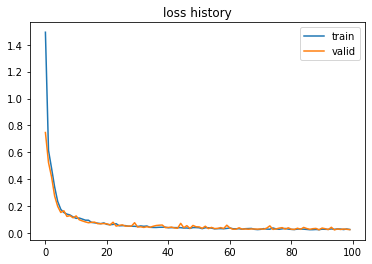

In [32]:
net = train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=100)

# make prediction

In [33]:
import time
s = time.time()
y_pred = net(X_test).cpu().detach().numpy()
origin_pred_time = time.time()-s
print('原始預測時間:',origin_pred_time)
y_pred = pd.DataFrame(y_pred,columns=y_col)
y_real = Y_test.cpu().detach().numpy()
y_real = pd.DataFrame(y_real,columns=y_col)

原始預測時間: 0.07481169700622559


In [34]:
y_pred.head()

,Light End Product Properties_Oxygen_wt%,Light End Product Properties_Methane_wt%,Light End Product Properties_Ethane_wt%,Light End Product Properties_Propane_wt%,Light End Product Properties_n-Butane_wt%,Light End Product Properties_i-Pentane_wt%,Light End Product Properties_n-Pentane_wt%,Light End Product Properties_tr2-Pentene_wt%,Light End Product Properties_Cyclopentane_wt%,Light End Product Properties_3-Methylpentane_wt%,...,"Heavy End Product Properties_2,2,3,3-Tetramethylhexane_wt%",Heavy End Product Properties_3-Methylnonane_wt%,Heavy End Product Properties_tert-Butylcyclohexane_wt%,Heavy End Product Properties_n-Decane_wt%,"Heavy End Product Properties_1,2-Diethylbenzene_wt%",Heavy End Product Properties_n-Undecane_wt%,Heavy End Product Properties_n-Pentylbenzene_wt%,Heavy End Product Properties_n-Dodecane_wt%,Heavy End Product Properties_n-Hexylbenzene_wt%,Heavy End Product Properties_n-Tridecane_wt%
0,0.0,0.0,0.0,0.615886,1.204901,9.938322,11.826215,0.249791,0.629300,20.458868,...,1.745351,4.534419,14.806535,1.829409,15.967436,0.385369,1.019969,0.006224,0.211257,0.0
1,0.0,0.0,0.0,0.190406,0.366043,2.979225,6.507488,0.074110,0.655148,20.211180,...,5.622944,14.464622,2.683613,4.025050,2.222659,0.827113,0.139875,0.016361,0.029388,0.0
2,0.0,0.0,0.0,0.327772,0.650253,5.231521,9.548148,0.129377,1.418120,19.041553,...,6.311741,16.072678,4.607271,5.416906,4.627136,1.079011,0.289130,0.021442,0.054750,0.0
3,0.0,0.0,0.0,0.418286,0.826145,6.842327,13.076939,0.170734,1.765444,15.638409,...,4.893307,12.162934,4.048999,3.236734,6.712962,0.682276,0.445285,0.012842,0.084746,0.0
4,0.0,0.0,0.0,0.276769,0.549727,4.465267,9.786848,0.104635,2.486256,22.403364,...,3.056236,7.575430,1.944188,5.123256,1.683785,1.066795,0.108788,0.018581,0.019113,0.0


In [35]:
y_real.head()

,Light End Product Properties_Oxygen_wt%,Light End Product Properties_Methane_wt%,Light End Product Properties_Ethane_wt%,Light End Product Properties_Propane_wt%,Light End Product Properties_n-Butane_wt%,Light End Product Properties_i-Pentane_wt%,Light End Product Properties_n-Pentane_wt%,Light End Product Properties_tr2-Pentene_wt%,Light End Product Properties_Cyclopentane_wt%,Light End Product Properties_3-Methylpentane_wt%,...,"Heavy End Product Properties_2,2,3,3-Tetramethylhexane_wt%",Heavy End Product Properties_3-Methylnonane_wt%,Heavy End Product Properties_tert-Butylcyclohexane_wt%,Heavy End Product Properties_n-Decane_wt%,"Heavy End Product Properties_1,2-Diethylbenzene_wt%",Heavy End Product Properties_n-Undecane_wt%,Heavy End Product Properties_n-Pentylbenzene_wt%,Heavy End Product Properties_n-Dodecane_wt%,Heavy End Product Properties_n-Hexylbenzene_wt%,Heavy End Product Properties_n-Tridecane_wt%
0,0.0,0.0,0.0,0.636957,1.232330,9.991961,11.942466,0.247212,0.625921,20.561838,...,1.821086,4.617033,15.279714,1.881402,16.294636,0.405993,1.031518,0.005368,0.208229,0.0
1,0.0,0.0,0.0,0.189108,0.361414,2.958685,6.462686,0.072821,0.651395,20.139559,...,5.695148,14.456672,2.695479,4.008540,2.233525,0.825175,0.140631,0.017963,0.030159,0.0
2,0.0,0.0,0.0,0.325535,0.642617,5.198601,9.505660,0.128455,1.412370,19.034941,...,6.365313,16.146379,4.645135,5.442918,4.722159,1.114246,0.294179,0.023076,0.061987,0.0
3,0.0,0.0,0.0,0.410613,0.828544,6.769370,12.917273,0.168017,1.761958,15.577982,...,4.951428,12.435013,4.134115,3.255167,6.727531,0.670430,0.422437,0.013672,0.082842,0.0
4,0.0,0.0,0.0,0.268337,0.542182,4.422442,9.690178,0.105005,2.478599,22.338873,...,3.063371,7.634607,1.929239,5.146127,1.711432,1.053171,0.107144,0.018202,0.018356,0.0


# metric

In [36]:
res = pd.DataFrame(index=y_col,columns=['MSE','MAPE'])

for i in y_col:
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res = res.sort_values(by='MSE',ascending=False)
res.loc['AVG'] = res.mean(axis=0)
res

,MSE,MAPE
Heavy End Product Properties_Ethylcyclohexane_wt%,0.977379,140.459
Heavy End Product Properties_2-Methyloctane_wt%,0.516337,22.9636
Light End Product Properties_Methylcyclopentane_wt%,0.429167,1.16761
Heavy End Product Properties_n-Nonane_wt%,0.41691,9.89979
Heavy End Product Properties_n-Octane_wt%,0.264575,3116.01
...,...,...
Heart Cut Product Properties_n-Tridecane_wt%,0,NaN
Heavy End Product Properties_Oxygen_wt%,0,NaN
Heavy End Product Properties_Methane_wt%,0,NaN
Heavy End Product Properties_n-Tridecane_wt%,0,NaN


#  wrap model

In [37]:
t = df[col_names['sle']+col_names['shc']+col_names['she']].mean(axis=0) == 1
sp_one_col = t[t].index.tolist()
t = df[col_names['sle']+col_names['shc']+col_names['she']].mean(axis=0) == 0
sp_zero_col = t[t].index.tolist()
n_col = naphtha_col

In [38]:
class ANN_wrapper(object):
    def __init__(self,x_col,y_col,n_col,net):
        self.x_col = x_col
        self.y_col = y_col
        self.n_col = n_col
        self.net = net
        self.col_names = col_names
        self.s_col = s_col
        self.sp_one_col = sp_one_col
        self.sp_zero_col = sp_zero_col
        
    
    def inverse_reconstruction(self,xna,s,x):
        return x*(np.diag(xna@s.T).reshape(-1,1))/(100*xna)
    
    def reconstruction(self,xna,s):
        return (100*xna*s)/np.diag(xna@s.T).reshape(-1,1)
        
    def predict(self,x):
        xna = x[self.col_names['xna']].values
        
        x = torch.tensor(x.values,dtype=torch.float)
        
        # 預測組成
        y = self.net(x).detach().cpu().numpy()
        y = pd.DataFrame(y,columns=self.y_col)
        assert np.all(y.values >= 0)
        
        # 預測分離係數
        sp_pred = np.hstack((self.net.sle.detach().numpy(),
                             self.net.shc.detach().numpy(),
                             self.net.she.detach().numpy()))
        sp_pred = pd.DataFrame(sp_pred,columns=self.col_names['sle']+self.col_names['shc']+self.col_names['she'])
        
        #用修改過的xle,xhc,xhe重算分離係數 
        new_sle = self.inverse_reconstruction(xna,sp_pred.iloc[:,:54].values,y.iloc[:,:54].values)
        new_shc = self.inverse_reconstruction(xna,sp_pred.iloc[:,54:-54].values,y.iloc[:,54:-54].values)
        new_she = self.inverse_reconstruction(xna,sp_pred.iloc[:,-54:].values,y.iloc[:,-54:].values)
        
        # update 分離係數
        sp_pred[col_names['sle']].update(new_sle)
        sp_pred[col_names['shc']].update(new_shc)
        sp_pred[col_names['she']] = 1 - sp_pred[col_names['sle']].values - sp_pred[col_names['shc']].values #總合為1
        
        # 分離係數有些都是1有些都是0
        sp_pred[self.sp_one_col] = 1
        sp_pred[self.sp_zero_col] = 0
        
        # 再用分離係數重算組成
        y[col_names['xle']] = self.reconstruction(xna,sp_pred[col_names['sle']])
        y[col_names['xhc']] = self.reconstruction(xna,sp_pred[col_names['shc']])
        y[col_names['xhe']] = self.reconstruction(xna,sp_pred[col_names['she']])
        
        # sort columns
        sp_pred = sp_pred[self.s_col]
        
        return y,sp_pred

In [39]:
model = ANN_wrapper(x_col,y_col,n_col,net.eval())

# test ANN_wrapper

In [40]:
data = pd.read_csv(root+'train.csv',index_col=0).loc[test_idx,:].reset_index(drop=True)
x = data[x_col]
y_real = data[y_col]
x.head()

,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_C7+ in Light End (Input)_wt%,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C6P- in Heart Cut (Input)_wt%,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,...,"Naphtha Properties_2,2,3,3-Tetramethylhexane_wt%",Naphtha Properties_3-Methylnonane_wt%,Naphtha Properties_tert-Butylcyclohexane_wt%,Naphtha Properties_n-Decane_wt%,"Naphtha Properties_1,2-Diethylbenzene_wt%",Naphtha Properties_n-Undecane_wt%,Naphtha Properties_n-Pentylbenzene_wt%,Naphtha Properties_n-Dodecane_wt%,Naphtha Properties_n-Hexylbenzene_wt%,Naphtha Properties_n-Tridecane_wt%
0,20.0,2.5,90.0,0.5,0.0,0.0,0.0,0.027000,0.052999,0.439996,...,0.485995,1.132989,3.490965,0.423996,3.353966,0.079999,0.194998,0.001000,0.038000,0.0
1,20.0,2.5,90.0,1.0,0.0,0.0,0.0,0.015000,0.029000,0.241998,...,1.223988,2.857971,0.527995,0.755992,0.408996,0.142999,0.024000,0.003000,0.005000,0.0
2,30.0,5.0,100.0,1.0,0.0,0.0,0.0,0.033994,0.067987,0.561893,...,1.058799,2.470531,0.702866,0.794849,0.668873,0.149972,0.038993,0.002999,0.007998,0.0
3,10.0,10.0,100.0,0.5,0.0,0.0,0.0,0.030999,0.062999,0.520990,...,0.928981,2.168957,0.709986,0.540989,1.075979,0.101998,0.062999,0.002000,0.012000,0.0
4,10.0,5.0,100.0,1.0,0.0,0.0,0.0,0.030000,0.060999,0.502995,...,0.632994,1.475985,0.368996,0.952990,0.306997,0.179998,0.018000,0.003000,0.003000,0.0


In [41]:
y_pred,sp_pred = model.predict(x)
y_pred.head()

,Light End Product Properties_Oxygen_wt%,Light End Product Properties_Methane_wt%,Light End Product Properties_Ethane_wt%,Light End Product Properties_Propane_wt%,Light End Product Properties_n-Butane_wt%,Light End Product Properties_i-Pentane_wt%,Light End Product Properties_n-Pentane_wt%,Light End Product Properties_tr2-Pentene_wt%,Light End Product Properties_Cyclopentane_wt%,Light End Product Properties_3-Methylpentane_wt%,...,"Heavy End Product Properties_2,2,3,3-Tetramethylhexane_wt%",Heavy End Product Properties_3-Methylnonane_wt%,Heavy End Product Properties_tert-Butylcyclohexane_wt%,Heavy End Product Properties_n-Decane_wt%,"Heavy End Product Properties_1,2-Diethylbenzene_wt%",Heavy End Product Properties_n-Undecane_wt%,Heavy End Product Properties_n-Pentylbenzene_wt%,Heavy End Product Properties_n-Dodecane_wt%,Heavy End Product Properties_n-Hexylbenzene_wt%,Heavy End Product Properties_n-Tridecane_wt%
0,0.0,0.0,0.0,0.613815,1.200850,9.904908,11.786453,0.248951,0.627184,20.390083,...,1.745350,4.534417,14.806529,1.829408,15.967430,0.385369,1.019999,0.006224,0.211257,0.0
1,0.0,0.0,0.0,0.190326,0.365890,2.977985,6.504779,0.074079,0.654875,20.202765,...,5.622943,14.464623,2.683613,4.025050,2.222658,0.827113,0.139884,0.016361,0.029388,0.0
2,0.0,0.0,0.0,0.327554,0.649818,5.228027,9.541771,0.129291,1.417173,19.028834,...,6.311739,16.072676,4.607271,5.416905,4.627135,1.079010,0.289144,0.021442,0.054750,0.0
3,0.0,0.0,0.0,0.421010,0.831525,6.886883,13.162093,0.171846,1.776940,15.740244,...,4.893307,12.162934,4.048998,3.236734,6.712960,0.682276,0.445291,0.012842,0.084746,0.0
4,0.0,0.0,0.0,0.278156,0.552483,4.487647,9.835900,0.105159,2.498717,22.515654,...,3.056236,7.575430,1.944188,5.123257,1.683785,1.066795,0.108792,0.018581,0.019113,0.0


In [42]:
y_real = y_real.reset_index(drop=True)
y_real.head()

,Light End Product Properties_Oxygen_wt%,Light End Product Properties_Methane_wt%,Light End Product Properties_Ethane_wt%,Light End Product Properties_Propane_wt%,Light End Product Properties_n-Butane_wt%,Light End Product Properties_i-Pentane_wt%,Light End Product Properties_n-Pentane_wt%,Light End Product Properties_tr2-Pentene_wt%,Light End Product Properties_Cyclopentane_wt%,Light End Product Properties_3-Methylpentane_wt%,...,"Heavy End Product Properties_2,2,3,3-Tetramethylhexane_wt%",Heavy End Product Properties_3-Methylnonane_wt%,Heavy End Product Properties_tert-Butylcyclohexane_wt%,Heavy End Product Properties_n-Decane_wt%,"Heavy End Product Properties_1,2-Diethylbenzene_wt%",Heavy End Product Properties_n-Undecane_wt%,Heavy End Product Properties_n-Pentylbenzene_wt%,Heavy End Product Properties_n-Dodecane_wt%,Heavy End Product Properties_n-Hexylbenzene_wt%,Heavy End Product Properties_n-Tridecane_wt%
0,0.0,0.0,0.0,0.636957,1.232330,9.991961,11.942466,0.247212,0.625921,20.561838,...,1.821086,4.617033,15.279714,1.881402,16.294636,0.405993,1.031518,0.005368,0.208229,0.0
1,0.0,0.0,0.0,0.189108,0.361414,2.958685,6.462686,0.072821,0.651395,20.139559,...,5.695148,14.456672,2.695479,4.008540,2.233525,0.825175,0.140631,0.017963,0.030159,0.0
2,0.0,0.0,0.0,0.325535,0.642617,5.198601,9.505660,0.128455,1.412370,19.034941,...,6.365313,16.146379,4.645135,5.442918,4.722159,1.114246,0.294179,0.023076,0.061987,0.0
3,0.0,0.0,0.0,0.410613,0.828544,6.769370,12.917273,0.168017,1.761958,15.577982,...,4.951428,12.435013,4.134115,3.255167,6.727531,0.670430,0.422437,0.013672,0.082842,0.0
4,0.0,0.0,0.0,0.268337,0.542182,4.422442,9.690178,0.105005,2.478599,22.338873,...,3.063371,7.634607,1.929239,5.146127,1.711432,1.053171,0.107144,0.018202,0.018356,0.0


In [43]:
y_pred.sum(axis=1).head(5)

0    300.0
1    300.0
2    300.0
3    300.0
4    300.0
dtype: float64

In [44]:
y_real.sum(axis=1).head(5)

0    300.000014
1    299.999993
2    300.000013
3    300.000013
4    299.999984
dtype: float64

In [45]:
data[col_names['case']].head()

,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_C7+ in Light End (Input)_wt%,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C6P- in Heart Cut (Input)_wt%
0,20.0,2.5,90.0,0.5
1,20.0,2.5,90.0,1.0
2,30.0,5.0,100.0,1.0
3,10.0,10.0,100.0,0.5
4,10.0,5.0,100.0,1.0


In [46]:
c6_col = col_names['xhc'][3:8] + col_names['xhc'][9:12]
c7_col = ['Light End Product Properties_2,2-Dimethylpentane_wt%']+col_names['xle'][16:]

In [47]:
print('C6P- 和 C7+確認')
pd.concat([y_real[c6_col].sum(axis=1),y_pred[c6_col].sum(axis=1)],axis=1).head()

C6P- 和 C7+確認


,0,1
0,0.496851,0.384554
1,0.995252,0.987607
2,0.985365,0.927366
3,0.491084,0.534181
4,0.982430,1.164426


In [61]:
sp_real.sum(axis=1),sp_pred.sum(axis=1)

(0       54.000011
 1       54.000003
 2       54.000003
 3       53.999993
 4       54.000014
           ...    
 1645    53.999999
 1646    54.000016
 1647    54.000003
 1648    53.999992
 1649    53.999992
 Length: 1650, dtype: float64,
 0       54.0
 1       54.0
 2       54.0
 3       54.0
 4       54.0
         ... 
 1645    54.0
 1646    54.0
 1647    54.0
 1648    54.0
 1649    54.0
 Length: 1650, dtype: float32)

真實分離係數


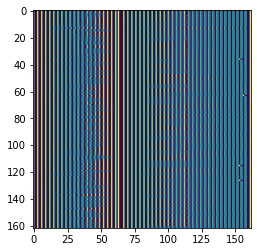

預測分離係數


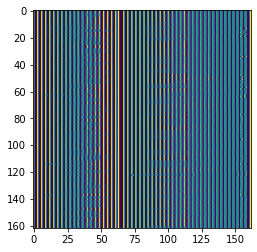

In [49]:
sp_real = data[s_col].head(162).values
print('真實分離係數')
plt.imshow(sp_real)
plt.show()
print('預測分離係數')
plt.imshow(sp_pred.head(162).values)

真實wt%


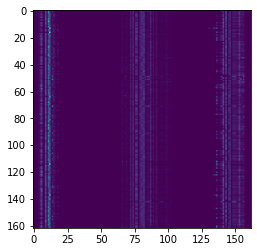

預測wt%


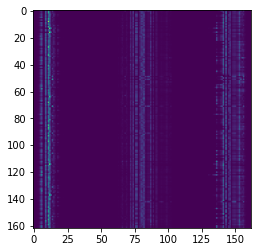

In [50]:
print('真實wt%')
plt.imshow(y_real.head(162).values)
plt.show()
print('預測wt%')
plt.imshow(y_pred.head(162).values)

In [51]:
sp_real = data[s_col]
res = pd.DataFrame(index=s_col,columns=['R2','MSE','MAPE'])

for i in s_col:
    res.loc[i,'R2'] = r2_score(sp_real[i],sp_pred[i])
    res.loc[i,'MSE'] = mean_squared_error(sp_real[i],sp_pred[i])
    res.loc[i,'MAPE'] = mape(sp_real[i],sp_pred[i])
res = res.sort_values(by='R2')
res.loc['AVG'] = res.mean(axis=0)
res

,R2,MSE,MAPE
Individual Component to Heavy End Split Factor_Propane_Ratio,-2.47764e+47,1.92429e-07,inf
"Individual Component to Light End Split Factor_1,2-Diethylbenzene_Ratio",-1.07276e+38,5.80709e-09,inf
Individual Component to Heavy End Split Factor_n-Butane_Ratio,-1.42012e+34,2.89609e-07,inf
"Individual Component to Light End Split Factor_1,2,3-Trimethylbenzene_Ratio",-4.75474e+33,8.3152e-09,7.87251e+23
Individual Component to Light End Split Factor_3-Methylnonane_Ratio,-5.4037e+30,5.59657e-08,6.72946e+21
...,...,...,...
Individual Component to Heavy End Split Factor_Oxygen_Ratio,1,0,NaN
Individual Component to Heart Cut Split Factor_Oxygen_Ratio,1,0,NaN
Individual Component to Heart Cut Split Factor_n-Tridecane_Ratio,1,0,NaN
Individual Component to Heavy End Split Factor_n-Tridecane_Ratio,1,0,0


In [52]:
res = pd.DataFrame(index=y_col,columns=['R2','MSE','MAPE'])

for i in y_col:
    res.loc[i,'R2'] = r2_score(y_real[i],y_pred[i])
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res = res.sort_values(by='MSE')
res.loc['AVG'] = res.mean(axis=0)
res

,R2,MSE,MAPE
Light End Product Properties_Oxygen_wt%,1,0,NaN
Heavy End Product Properties_H2O_wt%,1,0,NaN
Heavy End Product Properties_Ethane_wt%,1,0,NaN
Heavy End Product Properties_Methane_wt%,1,0,NaN
Heavy End Product Properties_Oxygen_wt%,1,0,NaN
...,...,...,...
Heavy End Product Properties_2-Methyloctane_wt%,0.988675,0.516335,22.9635
Heavy End Product Properties_Ethylcyclohexane_wt%,0.973088,0.977367,140.462
Light End Product Properties_Methylcyclopentane_wt%,0.977778,1.96837,1.22839
"Light End Product Properties_2,2-Dimethylpentane_wt%",-0.985082,2.1191,14.483


# save model

In [53]:
joblib.dump(model,'../model/ANN(58_to_y162(二合一)).pkl')
print('save done!')

save done!
